In [1]:
import pandas as pd
import cv2
import sys
import os

sys.path.append("../../")
from src import utils
#from src.dataset2D import MRIDataset2D
#from src.models2D import Model2DTimm
from codes.new.dataset import MRIDataset2D
from codes.new.model import Model2DTimm

import albumentations as A
from albumentations.pytorch import ToTensorV2

utils.set_seed(42)

results_dir = '../../results/preprocessed_data/'
labels=["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]


df_train = pd.read_csv(os.path.join(results_dir, 'df_train_imgs.csv'))
df_test = pd.read_csv(os.path.join(results_dir, 'df_test_imgs.csv'))
df_train.head(2)


,filename,Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion,path,patient_id,dim_x,dim_y,dim_z,spacing_x,spacing_y,spacing_z,view,img_path,npy_path,ratio
0,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...,0.014792
1,LISA_0001_LF_axi.nii.gz,0,0,0,0,0,0,0,/data/cristian/projects/med_data/rise-miccai/t...,LISA_0001,36,120,146,5.0,1.5,1.5,axi,/data/cristian/projects/med_data/rise-miccai/t...,/data/cristian/projects/med_data/rise-miccai/t...,0.014792


In [2]:

class args_class:
    def __init__(self):
        self.device = "cuda:3"
        self.label_cols = "Noise,Zipper,Positioning,Banding,Motion,Contrast,Distortion".split(",")
        self.seed = 42
        self.n_splits = 3
args = args_class()

In [3]:
# 📄 Leer CSVs
df_train_original = pd.read_csv(os.path.join(results_dir, 'df_train.csv'))

df_train["patient_id"] = df_train["filename"].str.extract(r"(LISA_\d+)")

df_train,df_test_back = utils.robust_split_by_patient(df_train_original,df_train,args)
df_test_back.shape

🎯 Labels usados para estratificación: ['Positioning', 'Banding']
Train    : Noise true dist: [384  49  45]
Train    : Zipper true dist: [362  93  23]
Train    : Positioning true dist: [423  43  12]
Train    : Banding true dist: [452  14  12]
Train    : Motion true dist: [345  75  58]
Train    : Contrast true dist: [333 123  22]
Train    : Distortion true dist: [391  51  36]
Testback : Noise true dist: [40 10  1]
Testback : Zipper true dist: [34 12  5]
Testback : Positioning true dist: [44  4  3]
Testback : Banding true dist: [49  1  1]
Testback : Motion true dist: [39  2 10]
Testback : Contrast true dist: [40 11  0]
Testback : Distortion true dist: [43  4  4]
df_train antes del merge :  (19120, 20)
df_train_original antes del merge :  (478, 18)
df_train_unique   antes del merge :  (216, 18)
df_train despues del merge :  (19120, 21)
['filename', 'Noise', 'Zipper', 'Positioning', 'Banding', 'Motion', 'Contrast', 'Distortion', 'path', 'patient_id', 'dim_x', 'dim_y', 'dim_z', 'spacing_x', 

/home/va0831/env_cris/lib64/python3.9/site-packages/sklearn/model_selection/_split.py:950: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


(2040, 20)

In [4]:
df_train_original["patient_id"]

0      LISA_0001
1      LISA_0001
2      LISA_0001
3      LISA_0002
4      LISA_0002
         ...    
524    LISA_2096
525    LISA_2097
526    LISA_2098
527    LISA_2099
528    LISA_2100
Name: patient_id, Length: 529, dtype: object

In [5]:
# ✅ Crea el dataset (usa `use_augmentation=False` para visualización clara)
dataset_vis = MRIDataset2D(df=df_test_back,is_train=True,use_augmentation=False,is_numpy=True,labels=labels,image_size=256,use_norma=False)

Loading arrays: 100%|██████████| 2040/2040 [00:00<00:00, 4085.53it/s]


In [6]:
import torch
model = Model2DTimm(base_model = "maxvit_nano_rw_256.sw_in1k",
                 in_channels= 1,
                 num_labels = 7,
                 num_classes = 3,
                 pretrained = True,
                 head_type  ="label_tokens",
                 #head_config = None,
                 use_view = True)

#save_dir = "/data/cristian/projects/med_data/rise-miccai/task-1/2d_models/results/maxvit_nano_rw_256.sw_in1k2D_final"
#save_dir = "/data/cristian/projects/med_data/rise-miccai/task-1/2d_models/results/maxvit_nano_rw_256.sw_in1k2D_finalratio0.1"
save_dir = "/data/cristian/projects/med_data/rise-miccai/task-1/2d_models/results/maxvit_nano_rw_256_flv3_8_0.1"
save_dir = "/data/cristian/projects/med_data/rise-miccai/task-1/2d_models/results/lisa_clean_label_tokens_testback2"


fold = 1
model.load_state_dict(torch.load(f"{save_dir}/model_fold{fold}.pt"))
model.to(args.device)

/home/va0831/env_cris/lib64/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model2DTimm(
  (backbone): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MaxxVitBlock(
            (conv): MbConvBlock(
              (shortcut): Downsample2d(
                (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
                (expand): Identity()
              )
              (pre_norm): BatchNormAct2d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
              (down): Identity()
              (conv1_1x1): Conv

In [7]:
label_cols = ["Noise", "Zipper", "Positioning", "Banding", "Motion", "Contrast", "Distortion"]
label_name = "Zipper"
label_idx = label_cols.index(label_name)

cnt = 0
idx = 0
list_idx = []
# 🔍 Recorremos el dataset hasta encontrar un ejemplo con Zipper == 2
while idx<len(dataset_vis):
    _, y, _, _ = dataset_vis[idx]  # y es tensor de shape (7,)
    if y[label_idx].item() == 2:
        cnt+=1
        list_idx.append(idx+15)
        idx+=40
        print(f"✅ Encontrado: idx={idx}, {label_name}=2")
        
    if cnt>10:
       break
    idx +=1

✅ Encontrado: idx=1120, Zipper=2
✅ Encontrado: idx=1200, Zipper=2
✅ Encontrado: idx=1720, Zipper=2
✅ Encontrado: idx=1880, Zipper=2
✅ Encontrado: idx=1921, Zipper=2


In [8]:
list_idx = [1855]

In [9]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

ANALISIS_LIST = []
ANALISIS_LIST2 = []
def plot_group_indices(model, dataset, args, indices, label_name, ncols=6, figsize_per_col=3.0):
    """
    Plotea un grupo de índices (mismo volumen) en una grilla.
    Para cada imagen muestra y_true, y_pred y p0/p1/p2 en el título.

    Params:
        model: modelo ya en eval() y en el device correspondiente
        dataset: tu MRIDataset2D (o similar)
        args: debe tener .device y .label_cols
        indices: lista de índices (int) del dataset para este volumen
        label_name: str, por ejemplo "Banding"
        ncols: columnas del grid
        figsize_per_col: ancho por columna (para escalar el tamaño)
    """
    model.eval()
    label_idx = args.label_cols.index(label_name)

    # Ordena índices por si vienen desordenados (útil para ver la progresión de slices)
    indices = sorted(indices)

    n = len(indices)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(figsize_per_col * ncols, figsize_per_col * nrows))

    # Nombre del volumen para el título global (intenta leer del df si existe)
    try:
        base_name = dataset.df.iloc[indices[0]]["filename"]
    except Exception:
        # fallback: parsea del path
        try:
            base_name = dataset.df.iloc[indices[0]]["img_path"].split("/")[-1].rsplit("_", 1)[0]
        except Exception:
            base_name = f"group_of_{n}_slices"

    for j, idx in enumerate(indices):
        ax = plt.subplot(nrows, ncols, j+1)

        # Carga del dataset
        x, y, path, view = dataset[idx]        # x: (C,H,W), y: (7,), view: one-hot (3,)
        x_vis = x.clone()                       # para mostrar como imagen
        if x_vis.dim() == 3 and x_vis.shape[0] == 1:
            x_vis = x_vis.repeat(3, 1, 1)      # a RGB para visualizar bonito
        img_np = x_vis.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)

        # Forward (intenta con view si tu modelo lo requiere)
        with torch.no_grad():
            xx = x.unsqueeze(0).to(args.device)
            # algunos modelos esperan (x, view); otros solo (x)
            
            mean_val = float(xx.mean())
            std_val = float(xx.std())
            print(f"j={j} | std_val:",std_val)
            if std_val > 1e-6:
                xx_normalized = (xx - mean_val) / std_val
            else:
                xx_normalized = np.zeros_like(xx, dtype=np.float32)
            
            try:
                vv = view.unsqueeze(0).to(args.device)
                logits = model(xx_normalized,vv)  # (1, 7, 3)
            except TypeError:
                logits = model(xx_normalized)      # (1, 7, 3)

            ANALISIS_LIST.append([xx,xx_normalized,vv])
            probs = F.softmax(logits[0, label_idx], dim=-1).detach().cpu().numpy()  # (3,)
            y_pred = int(np.argmax(probs))

        y_true = int(y[label_idx].item()) if torch.is_tensor(y) else int(y[label_idx])

        # Mostrar imagen
        ax.imshow(img_np, cmap=None)
        ax.axis("off")

        # Título con colores según acierto
        color = "tab:green" if y_pred == y_true else "tab:red"
        title = (f"j={j} |{label_name} | y={y_true} pred={y_pred}\n"
                 f"p0={probs[0]:.2f} p1={probs[1]:.2f} p2={probs[2]:.2f}")
        ax.set_title(title, fontsize=9, color=color)

    plt.suptitle(f"{base_name} — {label_name} ({n} slices)", fontsize=12)
    plt.tight_layout()
    plt.show()


In [29]:
import math, numpy as np, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def _pick_default_target_layer(model):
    """
    Intenta encontrar una capa 'conv' razonable para Grad-CAM.
    Ajusta esto si usas otro backbone.
    """
    # Timm MaxViT típico:
    try:
        return model.backbone.stages[3].blocks[-1].conv.norm2
    except Exception:
        pass
    # Última capa con atributo 'conv' que tenga grad
    for name in reversed(list(dict(model.named_modules()).keys())):
        m = dict(model.named_modules())[name]
        if hasattr(m, 'weight') or 'conv' in name.lower():
            return m
    # fallback
    return list(model.modules())[-1]

def _pick_default_target_layer_new(model):
    try:
        return model.backbone.stages[3].blocks[-1].conv.conv2_kxk
    except Exception:
        # fallback robusto
        for name, m in reversed(list(model.named_modules())):
            if 'conv2_kxk' in name:
                return m
        return list(model.modules())[-1]

def _gradcam_on_image(img_np, cam, alpha=0.5):
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    heatmap = plt.cm.jet(cam)[..., :3]  # (H,W,3)
    overlay = np.clip(img_np + alpha * heatmap, 0, 1)
    return overlay

def plot_group_indices_with_cam(
    model, dataset, args, indices, label_name,
    ncols=6, figsize_per_col=3.2,
    class_choice="pred",   # "pred" | 0 | 1 | 2
    target_layer=None,
    cam_alpha=0.5
):
    """
    Muestra una grilla de slices con Grad-CAM superpuesto y título con y/pred/probs.
    - class_choice="pred": usa la clase predicha para CAM; o un int 0/1/2 para forzarla.
    - target_layer: pasa tu capa conv/feature (p.ej. model.backbone.stages[3]....norm2).
    """
    model.eval()
    device = args.device
    label_idx = args.label_cols.index(label_name)

    indices = sorted(indices)
    n = len(indices)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    plt.figure(figsize=(figsize_per_col * ncols, figsize_per_col * nrows))

    # Elige capa objetivo (si no te pasan una)
    if target_layer is None:
        target_layer = _pick_default_target_layer(model)

    # título global
    try:
        vol_name = dataset.df.iloc[indices[0]]["filename"]
    except Exception:
        vol_name = f"group_of_{n}_slices"

    for j, idx in enumerate(indices):
        ax = plt.subplot(nrows, ncols, j+1)

        # --- Datos ---
        x, y, path, view = dataset[idx]  # x: (C,H,W), y: (7,)
        # Imagen para visualizar (3 canales)
        x_vis = x if x.shape[0] != 1 else x.repeat(3, 1, 1)
        img_np = x_vis.permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)

        # --- Hooks ---
        fmap = {"val": None}
        grads = {"val": None}

        def fwd_hook(m, inp, out):
            fmap["val"] = out.detach()

        def bwd_hook(m, gin, gout):
            grads["val"] = gout[0].detach()

        h1 = target_layer.register_forward_hook(fwd_hook)
        h2 = target_layer.register_full_backward_hook(bwd_hook)

        # --- Forward & backward ---
        xx = x.unsqueeze(0).to(device)
        mean_val = float(xx.mean())
        std_val  = float(xx.std())
        print(f"j={j} | std_val:",std_val)
        if std_val > 1e-6:
            xx_normalized = (xx - mean_val) / std_val
        else:
            xx_normalized = np.zeros_like(xx, dtype=np.float32)
        try:
            vv = view.unsqueeze(0).to(device)
            logits = model(xx_normalized,vv)  # (1, 7, 3)
        except TypeError:
            logits = model(xx_normalized)

        ANALISIS_LIST2.append([xx,xx_normalized,vv])
        probs_vec = F.softmax(logits[0, label_idx], dim=-1)  # (3,)
        y_pred = int(torch.argmax(probs_vec).item())
        y_true = int(y[label_idx].item()) if torch.is_tensor(y) else int(y[label_idx])

        # clase para cam
        cls = y_pred if class_choice == "pred" else int(class_choice)

        # backward
        model.zero_grad(set_to_none=True)
        score = logits[0, label_idx, cls]
        # Asegúrate de NO usar autocast aquí
        score.backward(retain_graph=False)

        # --- Grad-CAM ---
        # fmap: (B, C, Hf, Wf), grads: (B, C, Hf, Wf)
        fm = fmap["val"]
        gd = grads["val"]
        if fm is None or gd is None:
            # Si no hubo grad (capa mal elegida), no cam
            cam = np.zeros_like(img_np[..., 0])
        else:
            # pesos: GAP de gradientes
            weights = gd.mean(dim=(2, 3), keepdim=True)            # (B,C,1,1)
            cam_map = (weights * fm).sum(dim=1, keepdim=False)     # (B,Hf,Wf)
            cam_map = F.relu(cam_map)[0].cpu().numpy()
            # resize a tamaño de la imagen
            from PIL import Image
            cam_img = Image.fromarray((cam_map - cam_map.min()) / (cam_map.ptp() + 1e-8) * 255.0).resize(
                (img_np.shape[1], img_np.shape[0]), resample=Image.BILINEAR
            )
            cam = np.array(cam_img, dtype=np.float32) / 255.0

        # limpia hooks
        h1.remove(); h2.remove()

        # --- Overlay ---
        overlay = _gradcam_on_image(img_np, cam, alpha=cam_alpha)

        # Mostrar
        ax.imshow(overlay)
        ax.axis("off")
        color = "tab:green" if y_pred == y_true else "tab:red"
        p0, p1, p2 = probs_vec.detach().cpu().numpy().tolist()
        ax.set_title(
            f"j {j} | {label_name} | y={y_true} pred={y_pred} (cls_cam={cls})\n"
            f"p0={p0:.2f} p1={p1:.2f} p2={p2:.2f}",
            fontsize=9, color=color
        )

    plt.suptitle(f"{vol_name} — {label_name} (n={n})", fontsize=12)
    plt.tight_layout()
    plt.show()


Zipper
j=0 | std_val: 0.08022546023130417
j=1 | std_val: 0.09947773069143295
j=2 | std_val: 0.10691643506288528
j=3 | std_val: 0.11929752677679062
j=4 | std_val: 0.13527067005634308
j=5 | std_val: 0.15372012555599213
j=6 | std_val: 0.1738593578338623
j=7 | std_val: 0.17573963105678558
j=8 | std_val: 0.17874614894390106
j=9 | std_val: 0.1828233152627945
j=10 | std_val: 0.18790146708488464
j=11 | std_val: 0.19390197098255157
j=12 | std_val: 0.1872728019952774
j=13 | std_val: 0.18207766115665436
j=14 | std_val: 0.17844179272651672
j=15 | std_val: 0.17646166682243347
j=16 | std_val: 0.17619307339191437
j=17 | std_val: 0.16091610491275787


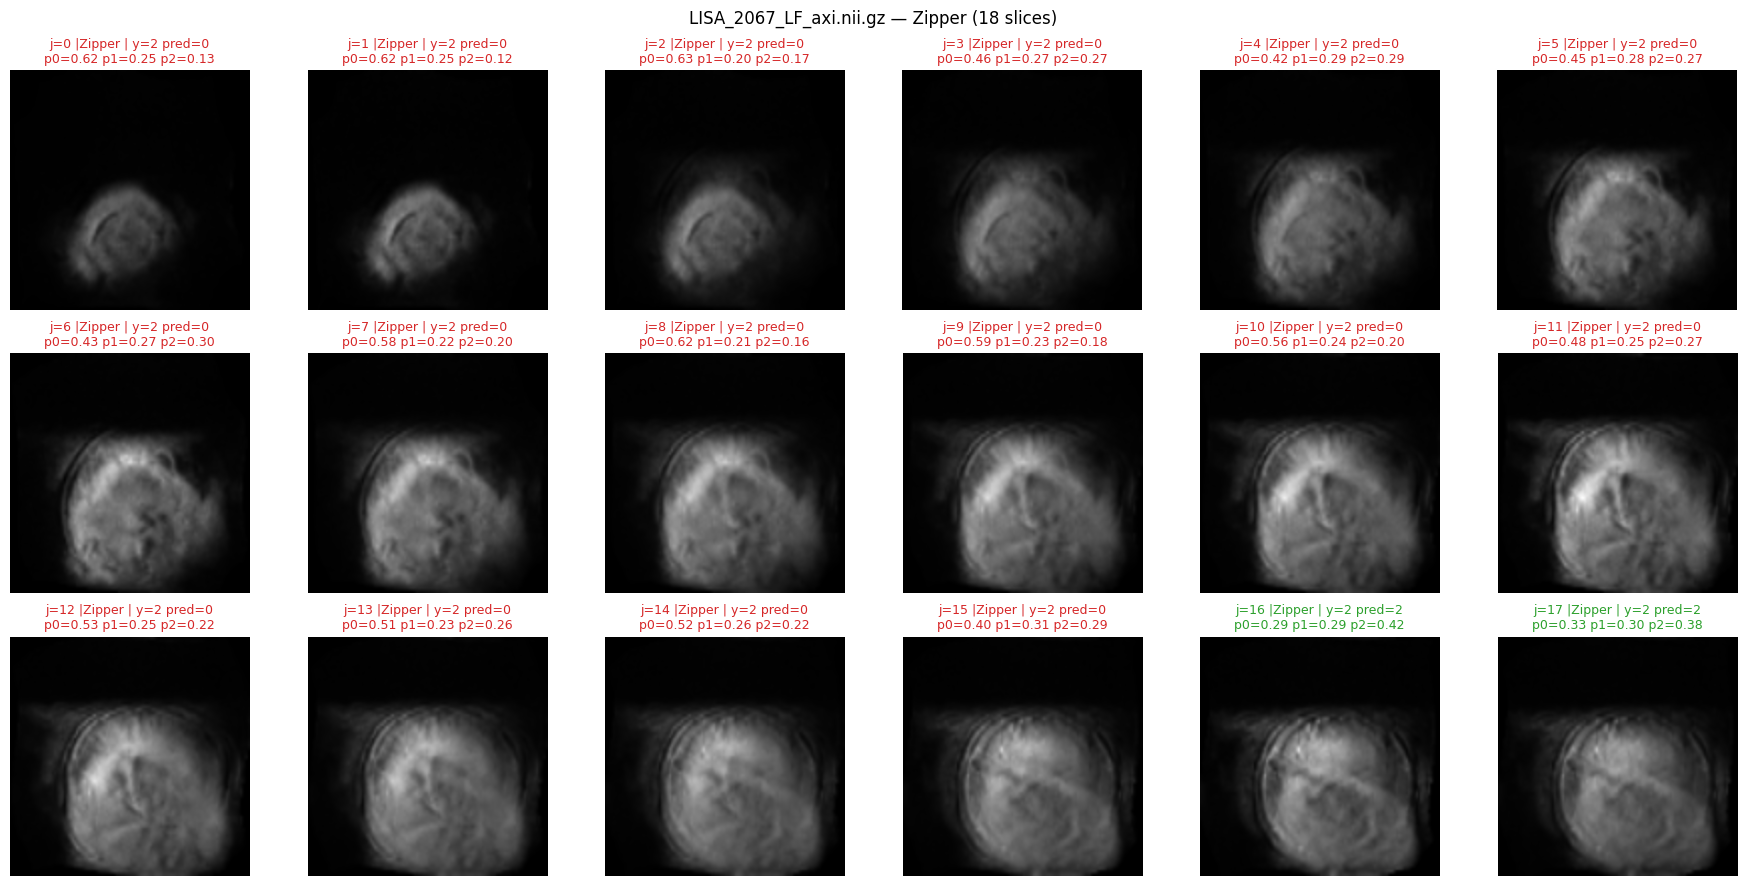

j=0 | std_val: 0.08022546023130417
j=1 | std_val: 0.09947773069143295
j=2 | std_val: 0.10691643506288528
j=3 | std_val: 0.11929752677679062
j=4 | std_val: 0.13527067005634308
j=5 | std_val: 0.15372012555599213
j=6 | std_val: 0.1738593578338623
j=7 | std_val: 0.17573963105678558


j=8 | std_val: 0.17874614894390106
j=9 | std_val: 0.1828233152627945
j=10 | std_val: 0.18790146708488464
j=11 | std_val: 0.19390197098255157
j=12 | std_val: 0.1872728019952774
j=13 | std_val: 0.18207766115665436
j=14 | std_val: 0.17844179272651672
j=15 | std_val: 0.17646166682243347
j=16 | std_val: 0.17619307339191437
j=17 | std_val: 0.16091610491275787


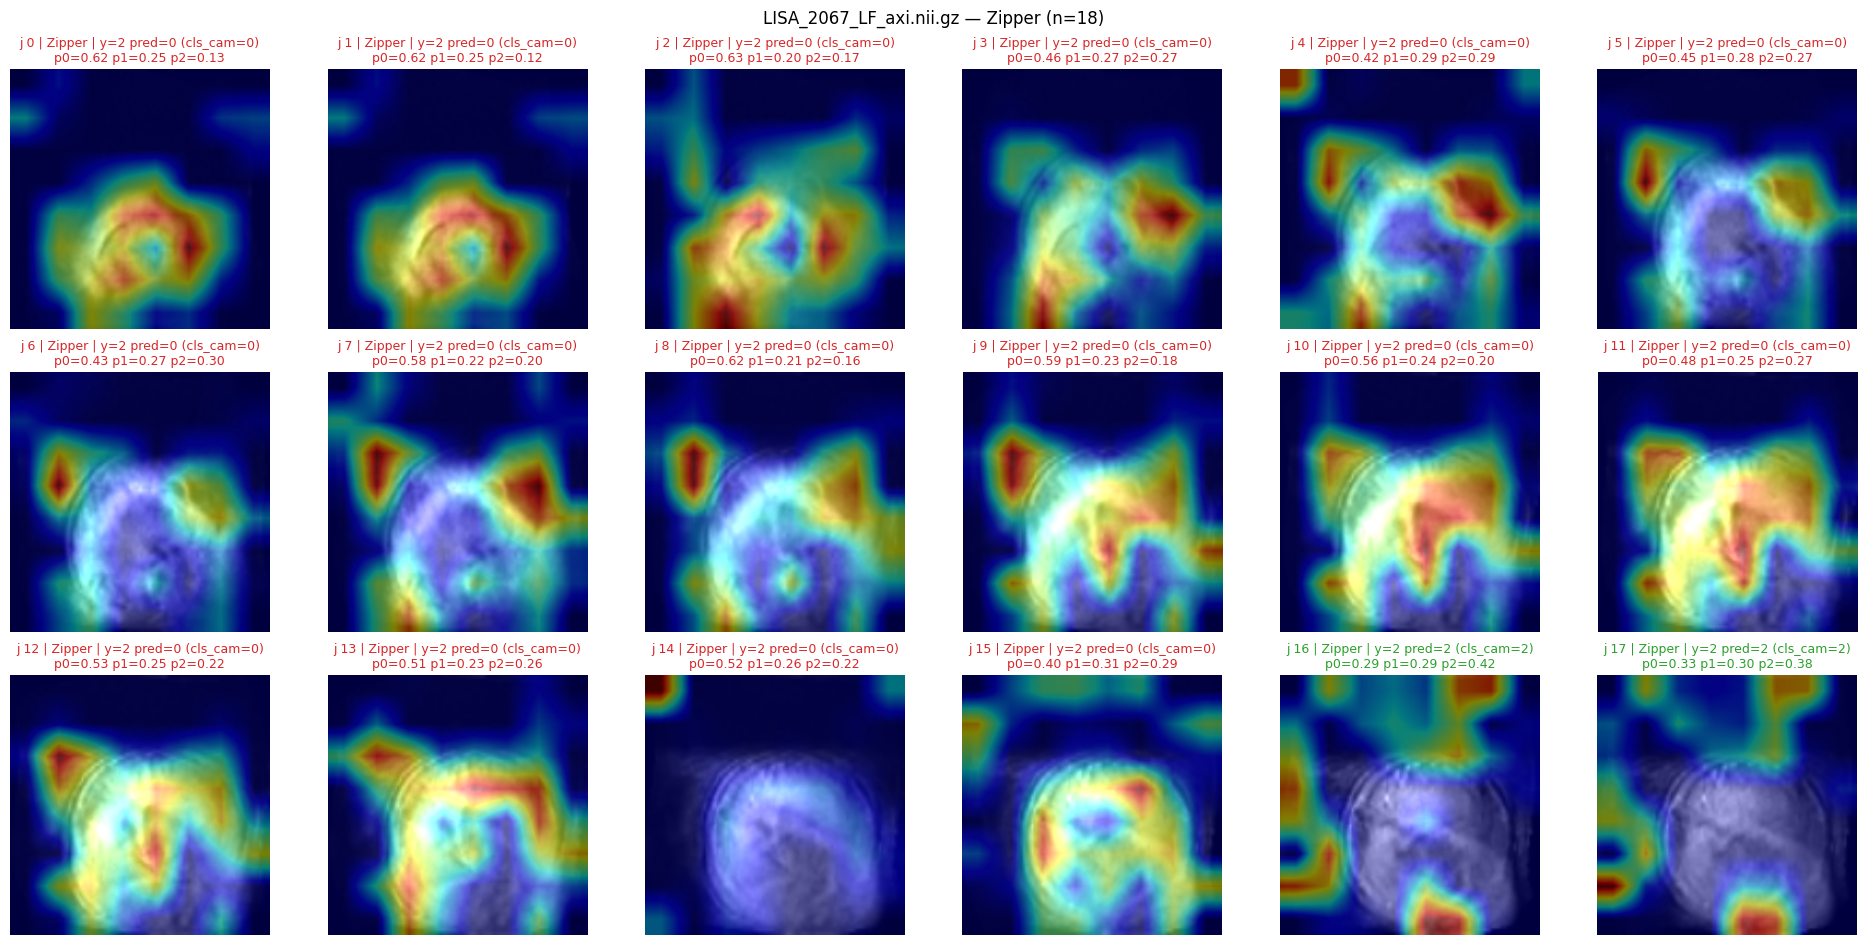

In [30]:
for idy in list_idx:
  print(label_name)
  plot_group_indices(model, dataset_vis, args, range(idy-9,idy+9), label_name=label_name, ncols=6)
  plot_group_indices_with_cam(
    model, dataset_vis, args, range(idy-9,idy+9),
    label_name=label_name,
    ncols=6,
    class_choice="pred",   # o 0/1/2 para forzar la clase del CAM
    target_layer=None,     # o pasa tl
    cam_alpha=0.5
  )

In [25]:
ANALISIS_LIST[15]

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:3'),
 tensor([[[[-0.8837, -0.8837, -0.8837,  ..., -0.8837, -0.8837, -0.8837],
           [-0.8837, -0.8837, -0.8837,  ..., -0.8837, -0.8837, -0.8837],
           [-0.8837, -0.8837, -0.8837,  ..., -0.8837, -0.8837, -0.8837],
           ...,
           [-0.8837, -0.8837, -0.8837,  ..., -0.8837, -0.8837, -0.8837],
           [-0.8837, -0.8837, -0.8837,  ..., -0.8837, -0.8837, -0.8837],
           [-0.8837, -0.8837, -0.8837,  ..., -0.8837, -0.8837, -0.8837]]]],
        device='cuda:3'),
 tensor([[1., 0., 0.]], device='cuda:3')]

In [26]:
ANALISIS_LIST[16]

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:3'),
 tensor([[[[-0.8614, -0.8614, -0.8614,  ..., -0.8614, -0.8614, -0.8614],
           [-0.8614, -0.8614, -0.8614,  ..., -0.8614, -0.8614, -0.8614],
           [-0.8614, -0.8614, -0.8614,  ..., -0.8614, -0.8614, -0.8614],
           ...,
           [-0.8614, -0.8614, -0.8614,  ..., -0.8614, -0.8614, -0.8614],
           [-0.8614, -0.8614, -0.8614,  ..., -0.8614, -0.8614, -0.8614],
           [-0.8614, -0.8614, -0.8614,  ..., -0.8614, -0.8614, -0.8614]]]],
        device='cuda:3'),
 tensor([[1., 0., 0.]], device='cuda:3')]

=== Estadísticas básicas ===
15 original          mean=0.1559, std=0.1765, min=0.0000, max=0.8097
15 normalized        mean=-0.0000, std=1.0000, min=-0.8837, max=3.7046
16 original          mean=0.1518, std=0.1762, min=0.0000, max=0.8701
16 normalized        mean=-0.0000, std=1.0000, min=-0.8614, max=4.0768


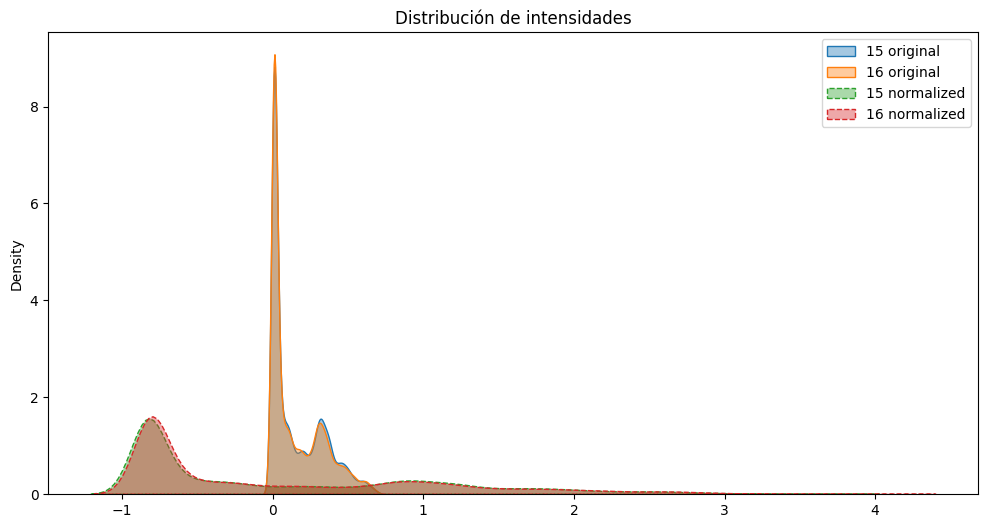


=== Métricas de similitud ===
Original 15 vs 16:   SSIM=0.9723, Cosine=0.9971, MSE=0.000321
Normalized 15 vs 16: SSIM=0.9459, Cosine=0.9951, MSE=0.009776
15 orig vs norm:           SSIM=0.1088, Cosine=0.7493, MSE=0.702523
16 orig vs norm:           SSIM=0.1044, Cosine=0.7577, MSE=0.701681


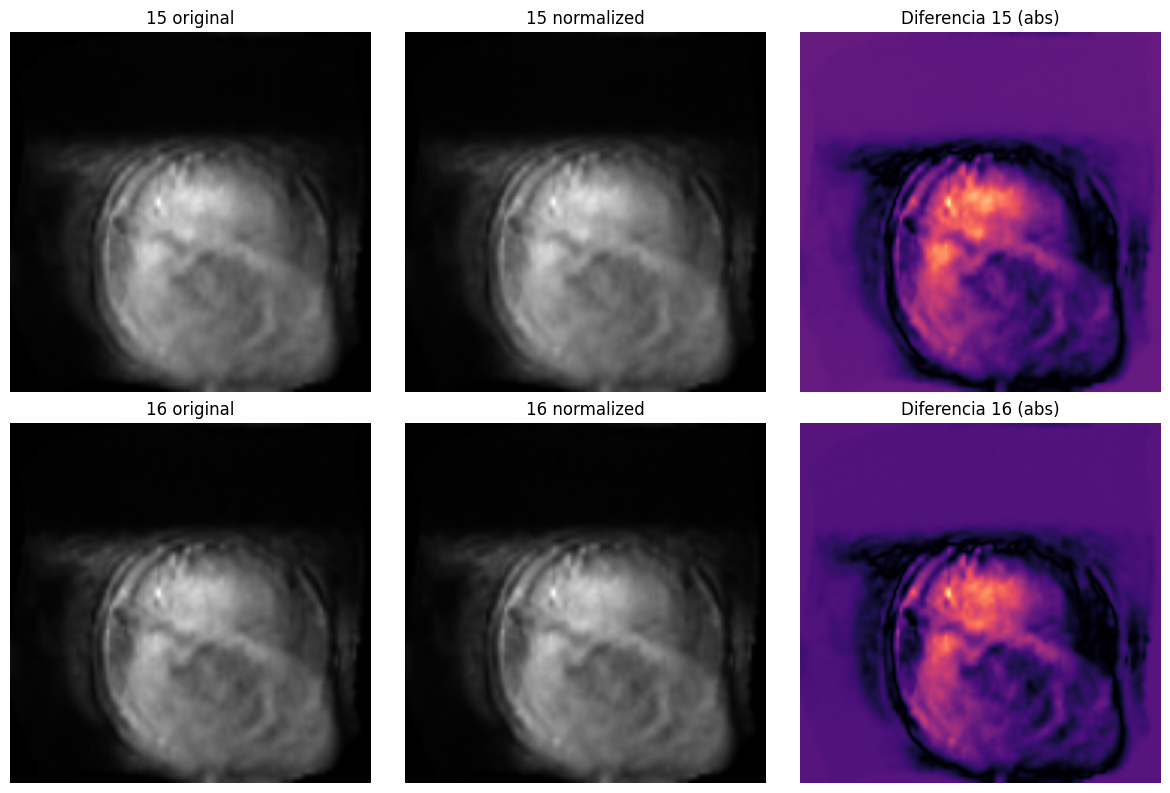

In [27]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import cosine

def similarity_metrics(img1, img2):
    """Calcula SSIM, similitud coseno y MSE entre dos tensores."""
    img1_np = img1.squeeze().cpu().numpy()
    img2_np = img2.squeeze().cpu().numpy()
    ssim_val = ssim(img1_np, img2_np, data_range=img2_np.max() - img2_np.min())
    cos_sim = 1 - cosine(img1_np.flatten(), img2_np.flatten())
    mse_val = np.mean((img1_np - img2_np) ** 2)
    return ssim_val, cos_sim, mse_val

def analizar_slices(analisis_list, idx_a=15, idx_b=16):
    # --- Cargar datos ---
    xx_a, xxn_a, view_a = analisis_list[idx_a]
    xx_b, xxn_b, view_b = analisis_list[idx_b]

    # Aplanar para histogramas
    xx_a_np  = xx_a.squeeze().cpu().numpy().flatten()
    xxn_a_np = xxn_a.squeeze().cpu().numpy().flatten()
    xx_b_np  = xx_b.squeeze().cpu().numpy().flatten()
    xxn_b_np = xxn_b.squeeze().cpu().numpy().flatten()

    # --- 1. Estadísticas ---
    print(f"=== Estadísticas básicas ===")
    for name, arr in [(f"{idx_a} original", xx_a_np),
                      (f"{idx_a} normalized", xxn_a_np),
                      (f"{idx_b} original", xx_b_np),
                      (f"{idx_b} normalized", xxn_b_np)]:
        print(f"{name:<20} mean={arr.mean():.4f}, std={arr.std():.4f}, min={arr.min():.4f}, max={arr.max():.4f}")

    # --- 2. Distribución de intensidades ---
    plt.figure(figsize=(12,6))
    sns.kdeplot(xx_a_np, label=f"{idx_a} original", fill=True, alpha=0.4)
    sns.kdeplot(xx_b_np, label=f"{idx_b} original", fill=True, alpha=0.4)
    sns.kdeplot(xxn_a_np, label=f"{idx_a} normalized", fill=True, alpha=0.4, linestyle="--")
    sns.kdeplot(xxn_b_np, label=f"{idx_b} normalized", fill=True, alpha=0.4, linestyle="--")
    plt.legend()
    plt.title("Distribución de intensidades")
    plt.show()

    # --- 3. Métricas de similitud ---
    print(f"\n=== Métricas de similitud ===")
    ssim_val, cos_sim, mse_val = similarity_metrics(xx_a, xx_b)
    print(f"Original {idx_a} vs {idx_b}:   SSIM={ssim_val:.4f}, Cosine={cos_sim:.4f}, MSE={mse_val:.6f}")
    ssim_val, cos_sim, mse_val = similarity_metrics(xxn_a, xxn_b)
    print(f"Normalized {idx_a} vs {idx_b}: SSIM={ssim_val:.4f}, Cosine={cos_sim:.4f}, MSE={mse_val:.6f}")
    ssim_val, cos_sim, mse_val = similarity_metrics(xx_a, xxn_a)
    print(f"{idx_a} orig vs norm:           SSIM={ssim_val:.4f}, Cosine={cos_sim:.4f}, MSE={mse_val:.6f}")
    ssim_val, cos_sim, mse_val = similarity_metrics(xx_b, xxn_b)
    print(f"{idx_b} orig vs norm:           SSIM={ssim_val:.4f}, Cosine={cos_sim:.4f}, MSE={mse_val:.6f}")

    # --- 4. Visualización lado a lado ---
    fig, axs = plt.subplots(2, 3, figsize=(12,8))

    axs[0,0].imshow(xx_a.squeeze().cpu(), cmap='gray')
    axs[0,0].set_title(f"{idx_a} original")
    axs[0,1].imshow(xxn_a.squeeze().cpu(), cmap='gray')
    axs[0,1].set_title(f"{idx_a} normalized")
    axs[0,2].imshow(torch.abs(xx_a - xxn_a).squeeze().cpu(), cmap='magma')
    axs[0,2].set_title(f"Diferencia {idx_a} (abs)")

    axs[1,0].imshow(xx_b.squeeze().cpu(), cmap='gray')
    axs[1,0].set_title(f"{idx_b} original")
    axs[1,1].imshow(xxn_b.squeeze().cpu(), cmap='gray')
    axs[1,1].set_title(f"{idx_b} normalized")
    axs[1,2].imshow(torch.abs(xx_b - xxn_b).squeeze().cpu(), cmap='magma')
    axs[1,2].set_title(f"Diferencia {idx_b} (abs)")

    for ax in axs.flat:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# --- Ejecutar análisis ---
analizar_slices(ANALISIS_LIST, idx_a=15, idx_b=16)


== Estadísticas básicas ==
15 original                  mean=0.15594 std=0.17646 min=0.00000 max=0.80966
15 normalized(GUARDADO)      mean=-0.00000 std=0.99999 min=-0.88372 max=3.70458
16 original                  mean=0.15177 std=0.17619 min=0.00000 max=0.87007
16 normalized(GUARDADO)      mean=-0.00000 std=0.99999 min=-0.86138 max=4.07676

== Similitud entre slices (original vs original) ==
{'name': 'orig_a_vs_orig_b', 'SSIM': 0.9722808692593574, 'Cosine': 0.9971443752968906, 'MSE': 0.0003214364987798035, 'KS_stat': 0.017730712890625, 'KS_p': 2.2259930784908344e-09, 'Wasserstein': 0.004822049333191738, 'KL': 0.01033500523100312}

== Similitud entre normalizados GUARDADOS ==
{'name': 'normSaved_a_vs_normSaved_b', 'SSIM': 0.9459216856419872, 'Cosine': 0.9951122548205893, 'MSE': 0.009775777347385883, 'KS_stat': 0.1794281005859375, 'KS_p': 0.0, 'Wasserstein': 0.024838526156121317, 'KL': 2.154198230225399}

== Cambio dentro de cada slice por la normalización GUARDADA ==
Slice 15: {'name':

Slice 16: {'name': 'b_orig_vs_normSaved', 'SSIM': 0.10435247734030127, 'Cosine': 0.7576653960372594, 'MSE': 0.7016814947128296, 'KS_stat': 0.6218719482421875, 'KS_p': 0.0, 'Wasserstein': 0.746245936944, 'KL': 1.3533311126482217}

== Comparando normalizaciones alternativas entre slices ==
zscore_slice: {'name': 'zscore_slice_a_vs_zscore_slice_b', 'SSIM': 0.9459216975293085, 'Cosine': 0.9951125579196617, 'MSE': 0.009775668382644653, 'KS_stat': 0.1794281005859375, 'KS_p': 0.0, 'Wasserstein': 0.024838388503465165, 'KL': 2.154200006655721}
robust_z: {'name': 'robust_z_a_vs_robust_z_b', 'SSIM': 0.9398830676182583, 'Cosine': 0.9960403573637733, 'MSE': 0.10854620486497879, 'KS_stat': 0.1614227294921875, 'KS_p': 0.0, 'Wasserstein': 0.1547042514367773, 'KL': 0.25239457909306207}
minmax_p1_99: {'name': 'minmax_p1_99_a_vs_minmax_p1_99_b', 'SSIM': 0.9646657150981426, 'Cosine': 0.9971613544482714, 'MSE': 0.0008267611847259104, 'KS_stat': 0.02117919921875, 'KS_p': 3.364138339807721e-13, 'Wasserstein'

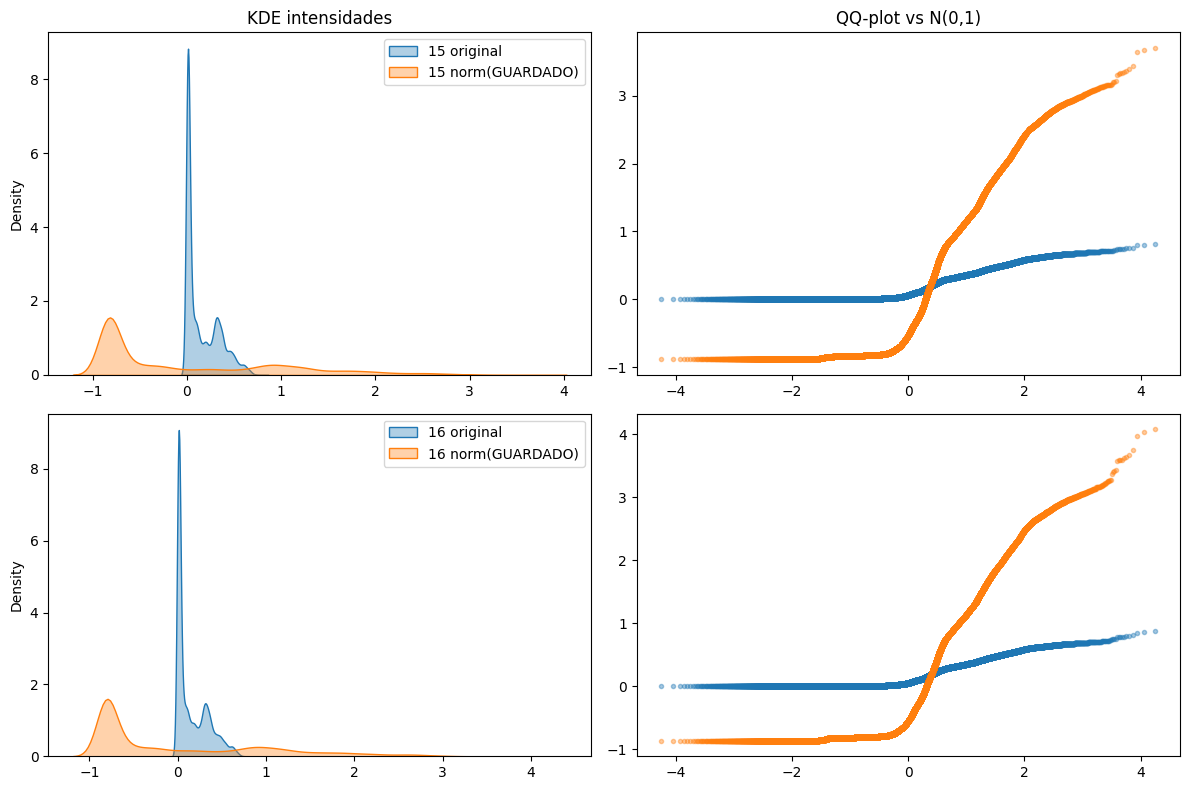

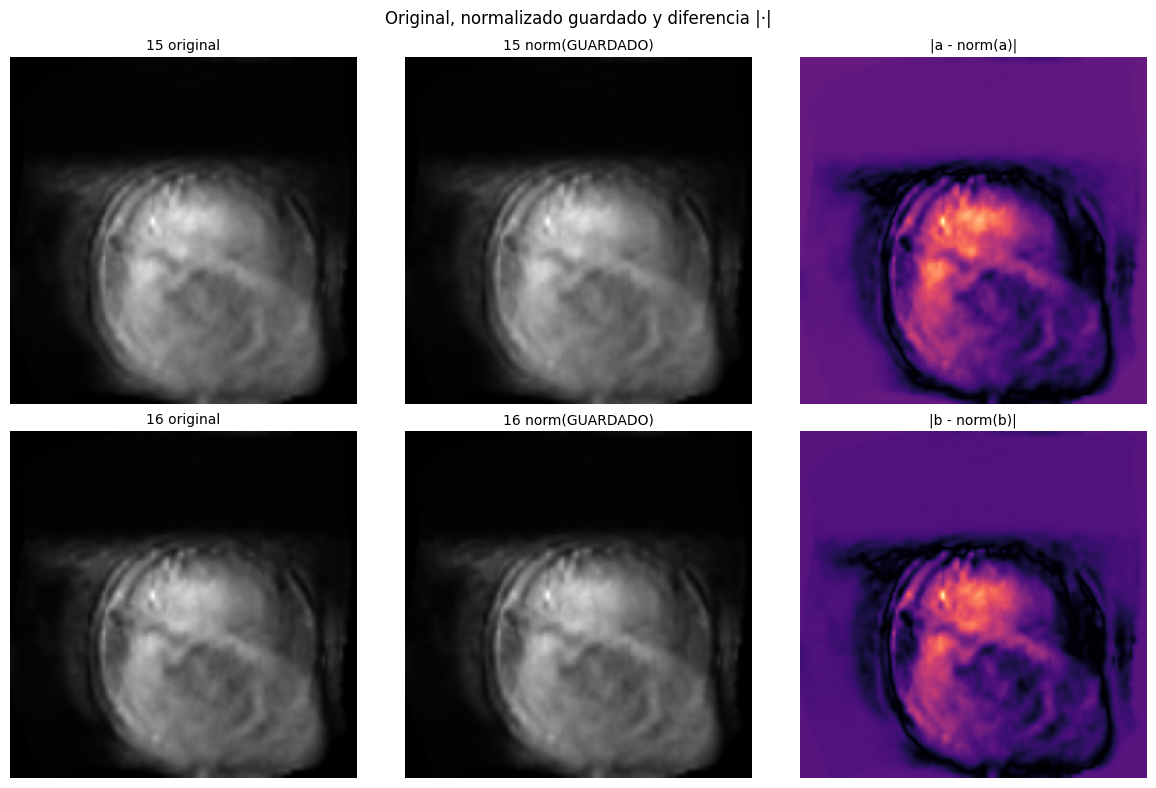

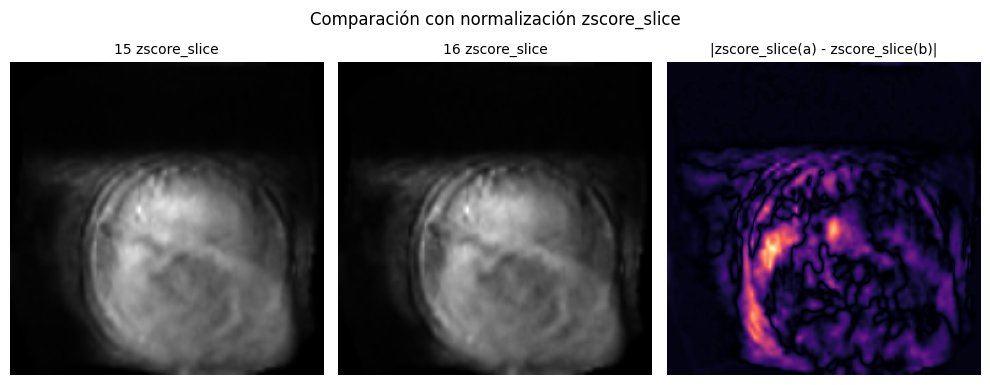

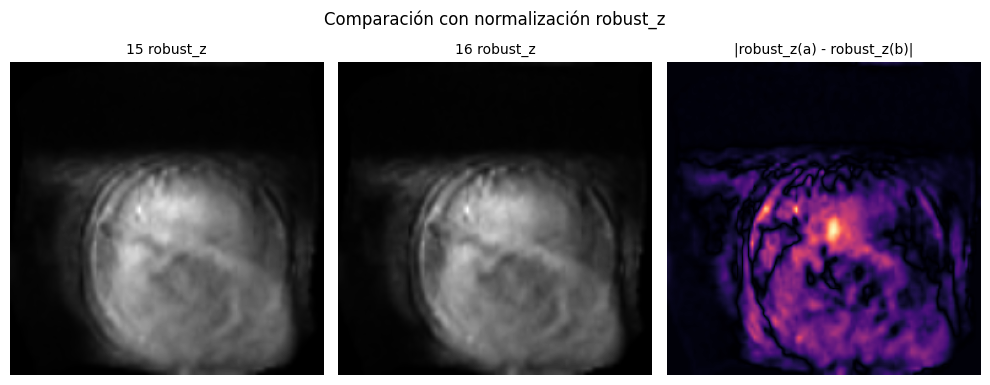

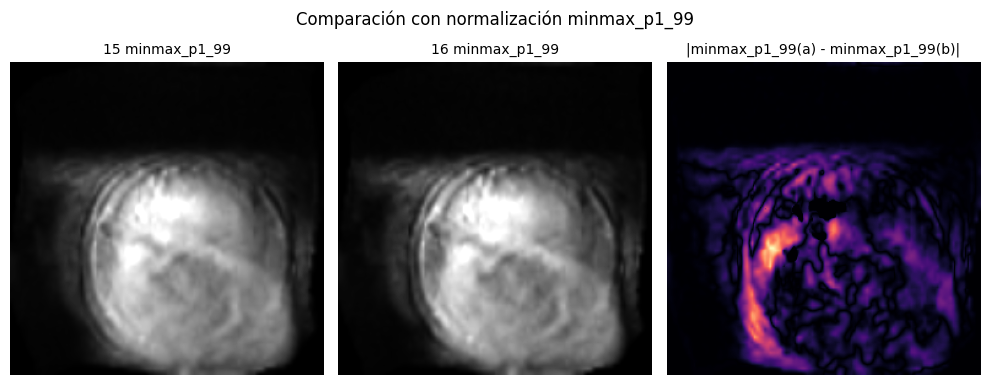

In [31]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp, entropy, probplot
from scipy.stats import wasserstein_distance

# ---------- Normalizaciones alternativas ----------
def zscore_slice(x):
    mu = x.mean()
    sd = x.std()
    return (x - mu) / (sd + 1e-6)

def zscore_fixed(x, mean, std):
    return (x - mean) / (std + 1e-6)

def zscore_robust(x):
    # mediana y MAD
    med = x.median()
    mad = (x - med).abs().median() + 1e-6
    return (x - med) / (1.4826 * mad)

def minmax_percentile(x, p_lo=1, p_hi=99):
    # recorte por percentiles y escalado a [0,1]
    v = x.flatten()
    lo = torch.quantile(v, p_lo/100.0)
    hi = torch.quantile(v, p_hi/100.0)
    x_cl = x.clamp(lo, hi)
    return (x_cl - lo) / (hi - lo + 1e-6)

# ---------- Métricas ----------
def to_np(x): return x.squeeze().detach().cpu().float().numpy()

def metrics_pair(a, b, name=""):
    A, B = to_np(a), to_np(b)
    A_f, B_f = A.flatten(), B.flatten()
    # SSIM
    ssim_val = ssim(A, B, data_range=B.max() - B.min() + 1e-6)
    # Cosine similarity (1 = idéntico)
    cos_sim = 1 - cosine(A_f, B_f)
    # MSE
    mse_val = float(np.mean((A_f - B_f)**2))
    # KS test (distribuciones)
    ks_stat, ks_p = ks_2samp(A_f, B_f)
    # Wasserstein (EMD 1D)
    wdist = wasserstein_distance(A_f, B_f)
    # KL (sobre histogramas suavizados para estabilidad)
    histA, bins = np.histogram(A_f, bins=256, range=(A.min(), A.max()), density=True)
    histB, _    = np.histogram(B_f, bins=bins, density=True)
    histA = (histA + 1e-12) / (histA.sum() + 1e-12)
    histB = (histB + 1e-12) / (histB.sum() + 1e-12)
    kl_ab = float(entropy(histA, histB))
    return dict(name=name, SSIM=ssim_val, Cosine=cos_sim, MSE=mse_val,
                KS_stat=ks_stat, KS_p=ks_p, Wasserstein=wdist, KL=kl_ab)

def kde_and_qq(ax_kde, ax_qq, arr, label):
    # Sanitizar -> 1D float64, sin NaN/Inf
    arr_np = np.asarray(arr.squeeze().detach().cpu(), dtype=np.float64).ravel()
    arr_np = arr_np[np.isfinite(arr_np)]
    if arr_np.size < 10:
        ax_kde.text(0.5, 0.5, f"{label}: pocos datos", ha='center', va='center', transform=ax_kde.transAxes)
        ax_qq.text(0.5, 0.5, f"{label}: pocos datos", ha='center', va='center', transform=ax_qq.transAxes)
        return

    # KDE (si la varianza es ~0, usa hist)
    if np.std(arr_np) < 1e-8:
        ax_kde.hist(arr_np, bins=10, alpha=0.35, density=True, label=label)
    else:
        sns.kdeplot(arr_np, ax=ax_kde, label=label, fill=True, alpha=0.35)

    # QQ-plot correcto: (osm, osr), (slope, intercept, r)
    (osm, osr), (slope, intercept, r) = probplot(arr_np, dist='norm')
    ax_qq.plot(osm, osr, '.', alpha=0.4, label=label)

def show_images_grid(tensors, titles, cmaps=None, suptitle=None, ncols=3, figsize=(12,8)):
    n = len(tensors); nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = np.array(axs).reshape(-1)
    for i, (t, ttl) in enumerate(zip(tensors, titles)):
        axs[i].imshow(to_np(t), cmap=(cmaps[i] if cmaps else 'gray'))
        axs[i].set_title(ttl, fontsize=10); axs[i].axis('off')
    for j in range(i+1, len(axs)): axs[j].axis('off')
    if suptitle: fig.suptitle(suptitle, fontsize=12)
    plt.tight_layout(); plt.show()

# ---------- Análisis principal ----------
def analizar_slices_v2(ANALISIS_LIST, idx_a=15, idx_b=16, dataset_mean=None, dataset_std=None):
    # Carga
    xx_a, xxn_a, view_a = ANALISIS_LIST[idx_a]
    xx_b, xxn_b, view_b = ANALISIS_LIST[idx_b]

    # 1) Stats básicas
    def stats(x):
        xnp = to_np(x)
        return dict(mean=float(xnp.mean()), std=float(xnp.std()),
                    min=float(xnp.min()), max=float(xnp.max()))
    print("== Estadísticas básicas ==")
    for name, x in [(f"{idx_a} original", xx_a),
                    (f"{idx_a} normalized(GUARDADO)", xxn_a),
                    (f"{idx_b} original", xx_b),
                    (f"{idx_b} normalized(GUARDADO)", xxn_b)]:
        s = stats(x)
        print(f"{name:<28} mean={s['mean']:.5f} std={s['std']:.5f} min={s['min']:.5f} max={s['max']:.5f}")

    # 2) Normalizaciones alternativas (aplicadas por nuestra cuenta)
    alt_a = {
        "zscore_slice": zscore_slice(xx_a),
        "robust_z":     zscore_robust(xx_a),
        "minmax_p1_99": minmax_percentile(xx_a),
    }
    alt_b = {
        "zscore_slice": zscore_slice(xx_b),
        "robust_z":     zscore_robust(xx_b),
        "minmax_p1_99": minmax_percentile(xx_b),
    }
    if (dataset_mean is not None) and (dataset_std is not None):
        alt_a["zscore_fixed"] = zscore_fixed(xx_a, dataset_mean, dataset_std)
        alt_b["zscore_fixed"] = zscore_fixed(xx_b, dataset_mean, dataset_std)

    # 3) Comparaciones: original vs original; normalized guardado vs guardado
    print("\n== Similitud entre slices (original vs original) ==")
    print(metrics_pair(xx_a, xx_b, "orig_a_vs_orig_b"))

    print("\n== Similitud entre normalizados GUARDADOS ==")
    print(metrics_pair(xxn_a, xxn_b, "normSaved_a_vs_normSaved_b"))

    print("\n== Cambio dentro de cada slice por la normalización GUARDADA ==")
    print(f"Slice {idx_a}:", metrics_pair(xx_a, xxn_a, "a_orig_vs_normSaved"))
    print(f"Slice {idx_b}:", metrics_pair(xx_b, xxn_b, "b_orig_vs_normSaved"))

    # 4) Comparar normalizaciones alternativas entre sí (a vs b)
    print("\n== Comparando normalizaciones alternativas entre slices ==")
    for k in alt_a.keys():
        if k in alt_b:
            print(f"{k}:", metrics_pair(alt_a[k], alt_b[k], f"{k}_a_vs_{k}_b"))

    # 5) KDE y QQ-plot por slice (original y normalizados)
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    kde_and_qq(axes[0,0], axes[0,1], xx_a, f"{idx_a} original")
    kde_and_qq(axes[0,0], axes[0,1], xxn_a, f"{idx_a} norm(GUARDADO)")
    kde_and_qq(axes[1,0], axes[1,1], xx_b, f"{idx_b} original")
    kde_and_qq(axes[1,0], axes[1,1], xxn_b, f"{idx_b} norm(GUARDADO)")
    axes[0,0].set_title("KDE intensidades"); axes[0,1].set_title("QQ-plot vs N(0,1)")
    axes[1,0].set_xlabel(""); axes[1,1].set_xlabel("")
    axes[0,0].legend(); axes[1,0].legend()
    plt.tight_layout(); plt.show()

    # 6) Visuales lado a lado y mapas de diferencia
    show_images_grid(
        [xx_a, xxn_a, torch.abs(xx_a-xxn_a),
         xx_b, xxn_b, torch.abs(xx_b-xxn_b)],
        [f"{idx_a} original", f"{idx_a} norm(GUARDADO)", f"|a - norm(a)|",
         f"{idx_b} original", f"{idx_b} norm(GUARDADO)", f"|b - norm(b)|"],
        cmaps=['gray','gray','magma','gray','gray','magma'],
        suptitle="Original, normalizado guardado y diferencia |·|"
    )

    # 7) Visuales con normalizaciones alternativas (mismo layout para a y b)
    for k in alt_a.keys():
        show_images_grid(
            [alt_a[k], alt_b[k], torch.abs(alt_a[k]-alt_b[k])],
            [f"{idx_a} {k}", f"{idx_b} {k}", f"|{k}(a) - {k}(b)|"],
            cmaps=['gray','gray','magma'],
            suptitle=f"Comparación con normalización {k}",
            ncols=3, figsize=(10,4)
        )

# ------ Ejecuta: si tienes mean/std globales del dataset, pásalos como tensores del mismo shape que xx (o escalares)
# ejemplo sin mean/std global:
analizar_slices_v2(ANALISIS_LIST, idx_a=15, idx_b=16)

# si tienes stats globales (por ejemplo args.mean == 0.5, args.std == 0.25 para 1 canal):
# dataset_mean = torch.tensor(0.5, device=ANALISIS_LIST[0][0].device)
# dataset_std  = torch.tensor(0.25, device=ANALISIS_LIST[0][0].device)
# analizar_slices_v2(ANALISIS_LIST, idx_a=15, idx_b=16, dataset_mean=dataset_mean, dataset_std=dataset_std)
